In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder


# 데이터 로드
df = pd.read_excel('BASEBALL_stats_15.xlsx')

# 상대팀 정보 추가
df['상대팀'] = df['팀명'].shift(-1)
df.loc[df.index % 2 == 1, '상대팀'] = df['팀명'].shift(1)

def determine_result(df):
    """
    승리여부 결정 함수
    """
    results = []
    for i in range(0, len(df), 2):
        score1 = df.loc[i, '득점']
        score2 = df.loc[i+1, '득점']
        if score1 > score2:
            results.extend(['승', '패'])
        elif score1 < score2:
            results.extend(['패', '승'])
        else:
            results.extend(['무', '무'])
    return results

df['승리여부'] = determine_result(df)

def calculate_team_stats(df, window=10):
    """
    각 팀의 최근 경기 성적을 계산하는 함수
    """
    team_stats = []
    
    for i in range(len(df)):
        team = df.loc[i, '팀명']
        date = df.loc[i, '날짜']
        
        # 과거 경기 추출
        past_games = df[
            (df['팀명'] == team) &
            (df['날짜'] < date)
        ].sort_values('날짜').tail(window)
        
        if len(past_games) < window:
            stats = {
                '최근승률': np.nan,
                '최근평균득점': np.nan,
                '최근평균타율': np.nan,
                '최근평균출루율': np.nan,
                '최근평균장타율': np.nan
            }
        else:
            stats = {
                '최근승률': (past_games['승리여부'] == '승').mean(),
                '최근평균득점': past_games['득점'].mean(),
                '최근평균타율': past_games['타율'].mean(),
                '최근평균출루율': past_games['출루율'].mean(),
                '최근평균장타율': past_games['장타율'].mean()
            }
        
        team_stats.append(stats)
    
    return pd.DataFrame(team_stats)

def calculate_matchup_stats(df, window=10):
    """
    상대팀과의 최근 전적을 계산하는 함수
    """
    matchup_stats = []
    
    for i in range(len(df)):
        team = df.loc[i, '팀명']
        opponent = df.loc[i, '상대팀']
        date = df.loc[i, '날짜']
        
        # 과거 매치업 추출
        past_matchups = df[
            ((df['팀명'] == team) & (df['상대팀'] == opponent)) &
            (df['날짜'] < date)
        ].sort_values('날짜').tail(window)
        
        if len(past_matchups) < window:
            stats = {
                '상대팀상대승률': np.nan,
                '상대팀상대평균득점': np.nan
            }
        else:
            stats = {
                '상대팀상대승률': (past_matchups['승리여부'] == '승').mean(),
                '상대팀상대평균득점': past_matchups['득점'].mean()
            }
        
        matchup_stats.append(stats)
    
    return pd.DataFrame(matchup_stats)

# 팀 스탯과 매치업 스탯 계산
team_stats_df = calculate_team_stats(df)
matchup_stats_df = calculate_matchup_stats(df)

# 데이터프레임 결합
df = pd.concat([df, team_stats_df, matchup_stats_df], axis=1)

# 시간 관련 피처 추가
df['요일'] = pd.to_datetime(df['날짜']).dt.dayofweek
df['주말'] = df['요일'].isin([5, 6]).astype(int)
df['월'] = pd.to_datetime(df['날짜']).dt.month

# 홈/원정 인코딩
df['홈원정_인코딩'] = (df['홈/원정'] == '홈').astype(int)

# 관중수 정규화
df['정규화관중수'] = df.groupby('경기장')['관중수'].transform(lambda x: (x - x.mean()) / x.std())

def prepare_features(df):
    """
    모델 학습을 위한 피처 준비
    """
    # 레이블 인코딩
    le = LabelEncoder()
    df['팀명_인코딩'] = le.fit_transform(df['팀명'])
    df['상대팀_인코딩'] = le.transform(df['상대팀'])
    df['경기장_인코딩'] = le.fit_transform(df['경기장'])
    
    # 학습에 사용할 피처 선택
    features = [
        '팀명_인코딩', '상대팀_인코딩', '경기장_인코딩', '홈원정_인코딩',
        '최근승률', '최근평균득점', '최근평균타율', '최근평균출루율', '최근평균장타율',
        '상대팀상대승률', '상대팀상대평균득점',
        '주말', '월', '정규화관중수'
    ]
    
    # 결측치 처리
    X = df[features].fillna(df[features].mean())
    
    # 타겟 변수
    y = (df['승리여부'] == '승').astype(int)
    
    return X, y

# 피처 준비
X, y = prepare_features(df)
print("사용되는 피처:", X.columns.tolist())




사용되는 피처: ['팀명_인코딩', '상대팀_인코딩', '경기장_인코딩', '홈원정_인코딩', '최근승률', '최근평균득점', '최근평균타율', '최근평균출루율', '최근평균장타율', '상대팀상대승률', '상대팀상대평균득점', '주말', '월', '정규화관중수']


In [30]:
X.tail(10)

,팀명_인코딩,상대팀_인코딩,경기장_인코딩,홈원정_인코딩,최근승률,최근평균득점,최근평균타율,최근평균출루율,최근평균장타율,상대팀상대승률,상대팀상대평균득점,주말,월,정규화관중수
14672,5,10,7,1,0.4,4.5,0.2378,0.3109,0.3331,0.6,4.4,1,4,0.713877
14673,10,5,7,0,0.3,2.5,0.1930,0.2506,0.2588,0.4,3.4,1,4,0.713877
14674,11,1,4,1,0.8,5.4,0.2574,0.3335,0.4211,0.6,6.6,1,4,0.444519
14675,1,11,4,0,0.5,4.8,0.2511,0.3300,0.3638,0.4,4.4,1,4,0.444519
14676,0,2,1,1,0.5,4.1,0.2340,0.3120,0.3686,0.7,5.3,1,4,1.750994
14677,2,0,1,0,0.5,5.3,0.2467,0.3512,0.3786,0.3,3.8,1,4,1.750994
14678,7,8,11,1,0.4,4.9,0.2691,0.3503,0.4003,0.4,5.4,1,4,1.444043
14679,8,7,11,0,0.8,6.0,0.3165,0.3734,0.4474,0.6,6.5,1,4,1.444043
14680,9,3,2,1,0.6,6.5,0.2907,0.3775,0.4588,0.7,7.2,1,4,2.107681
14681,3,9,2,0,0.3,3.2,0.1955,0.2918,0.3009,0.3,5.2,1,4,2.107681


In [29]:
y

0        1
1        0
2        1
3        0
4        1
        ..
14677    0
14678    1
14679    0
14680    1
14681    0
Name: 승리여부, Length: 14682, dtype: int64


RandomForest 모델 평가 결과:
정확도: 0.5138
정밀도: 0.5106
재현율: 0.4622
F1 점수: 0.4852


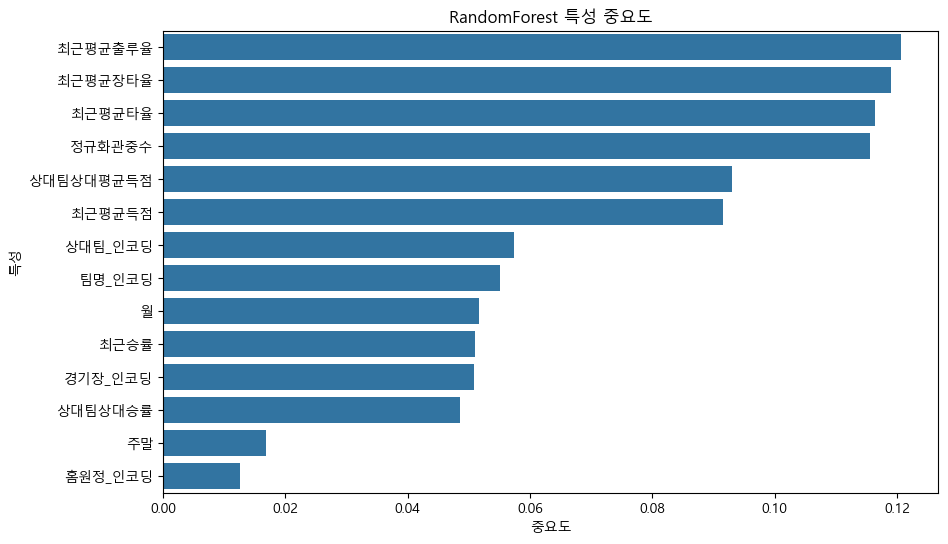


XGBoost 모델 평가 결과:
정확도: 0.5169
정밀도: 0.5132
재현율: 0.4931
F1 점수: 0.5030


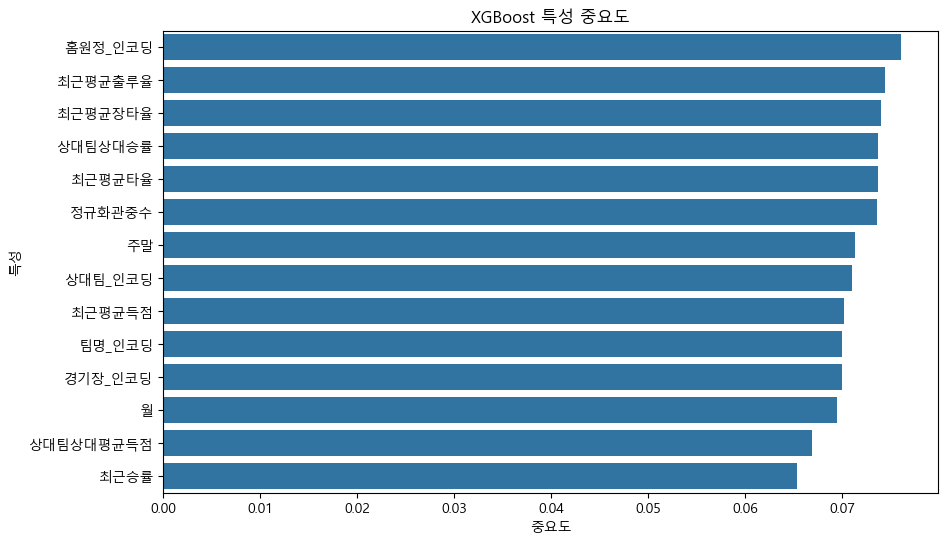


LightGBM 모델 평가 결과:
[LightGBM] [Info] Number of positive: 5710, number of negative: 6035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1259
[LightGBM] [Info] Number of data points in the train set: 11745, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486164 -> initscore=-0.055357
[LightGBM] [Info] Start training from score -0.055357
정확도: 0.5240
정밀도: 0.5225
재현율: 0.4629
F1 점수: 0.4909


In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕 폰트 사용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# 각 모델 학습 및 평가
for name, model in models.items():
    print(f"\n{name} 모델 평가 결과:")
    
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    
    # 성능 평가
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"정확도: {accuracy:.4f}")
    print(f"정밀도: {precision:.4f}")
    print(f"재현율: {recall:.4f}")
    print(f"F1 점수: {f1:.4f}")
    
    # 특성 중요도 시각화 (RandomForest와 XGBoost만)
    if name in ['RandomForest', 'XGBoost']:
        feature_importance = pd.DataFrame({
            '특성': X.columns,
            '중요도': model.feature_importances_
        }).sort_values('중요도', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance, x='중요도', y='특성')
        plt.title(f'{name} 특성 중요도')
        plt.show()




In [23]:
!pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 38.4 MB/s eta 0:00:00
